# TAREA 2: Laboratorio de métodos aplicados avanzados
### Autor: Sebastián Muñoz 
### Fecha: 05/10/22

## Carga de datos y limpieza 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import seaborn as sbn
import numpy.linalg as la
from scipy import stats
import pingouin as pg

%matplotlib inline

In [2]:
charls = pd.read_csv('../data/charls.csv')
#Se transforman los missing values para drinkly en valores NaN con el fin de poder ser reconocidos por Pandas para poder descatarlos de forma correcta.
charls['drinkly']=charls['drinkly'].replace('.m:missing',np.nan)
charls.dropna(inplace=True)
charls.reset_index(drop=True, inplace=True)
charls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34354 entries, 0 to 34353
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   cesd      34354 non-null  int64  
 1   child     34354 non-null  int64  
 2   drinkly   34354 non-null  object 
 3   female    34354 non-null  int64  
 4   hrsusu    34354 non-null  float64
 5   hsize     34354 non-null  int64  
 6   inid      34354 non-null  float64
 7   intmonth  34354 non-null  int64  
 8   married   34354 non-null  int64  
 9   retired   34354 non-null  int64  
 10  schadj    34354 non-null  int64  
 11  urban     34354 non-null  int64  
 12  wave      34354 non-null  int64  
 13  wealth    34354 non-null  float64
 14  age       34354 non-null  int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 3.9+ MB


Cargada la database, se identifica un total de 34371 observaciones, donde se distingue la presencia de variables ficticias, tales como: drinkly; female; married; retired y urban, las demás variables de la base de datos son cuantitativas.

A modo de limpiar la data, se removieron muestras que incluian valores NaN, que provenian principalmente desde la variable drinkly, descartando un total de 71 observaciones, dejando entonces un total de 34354 para análisis...

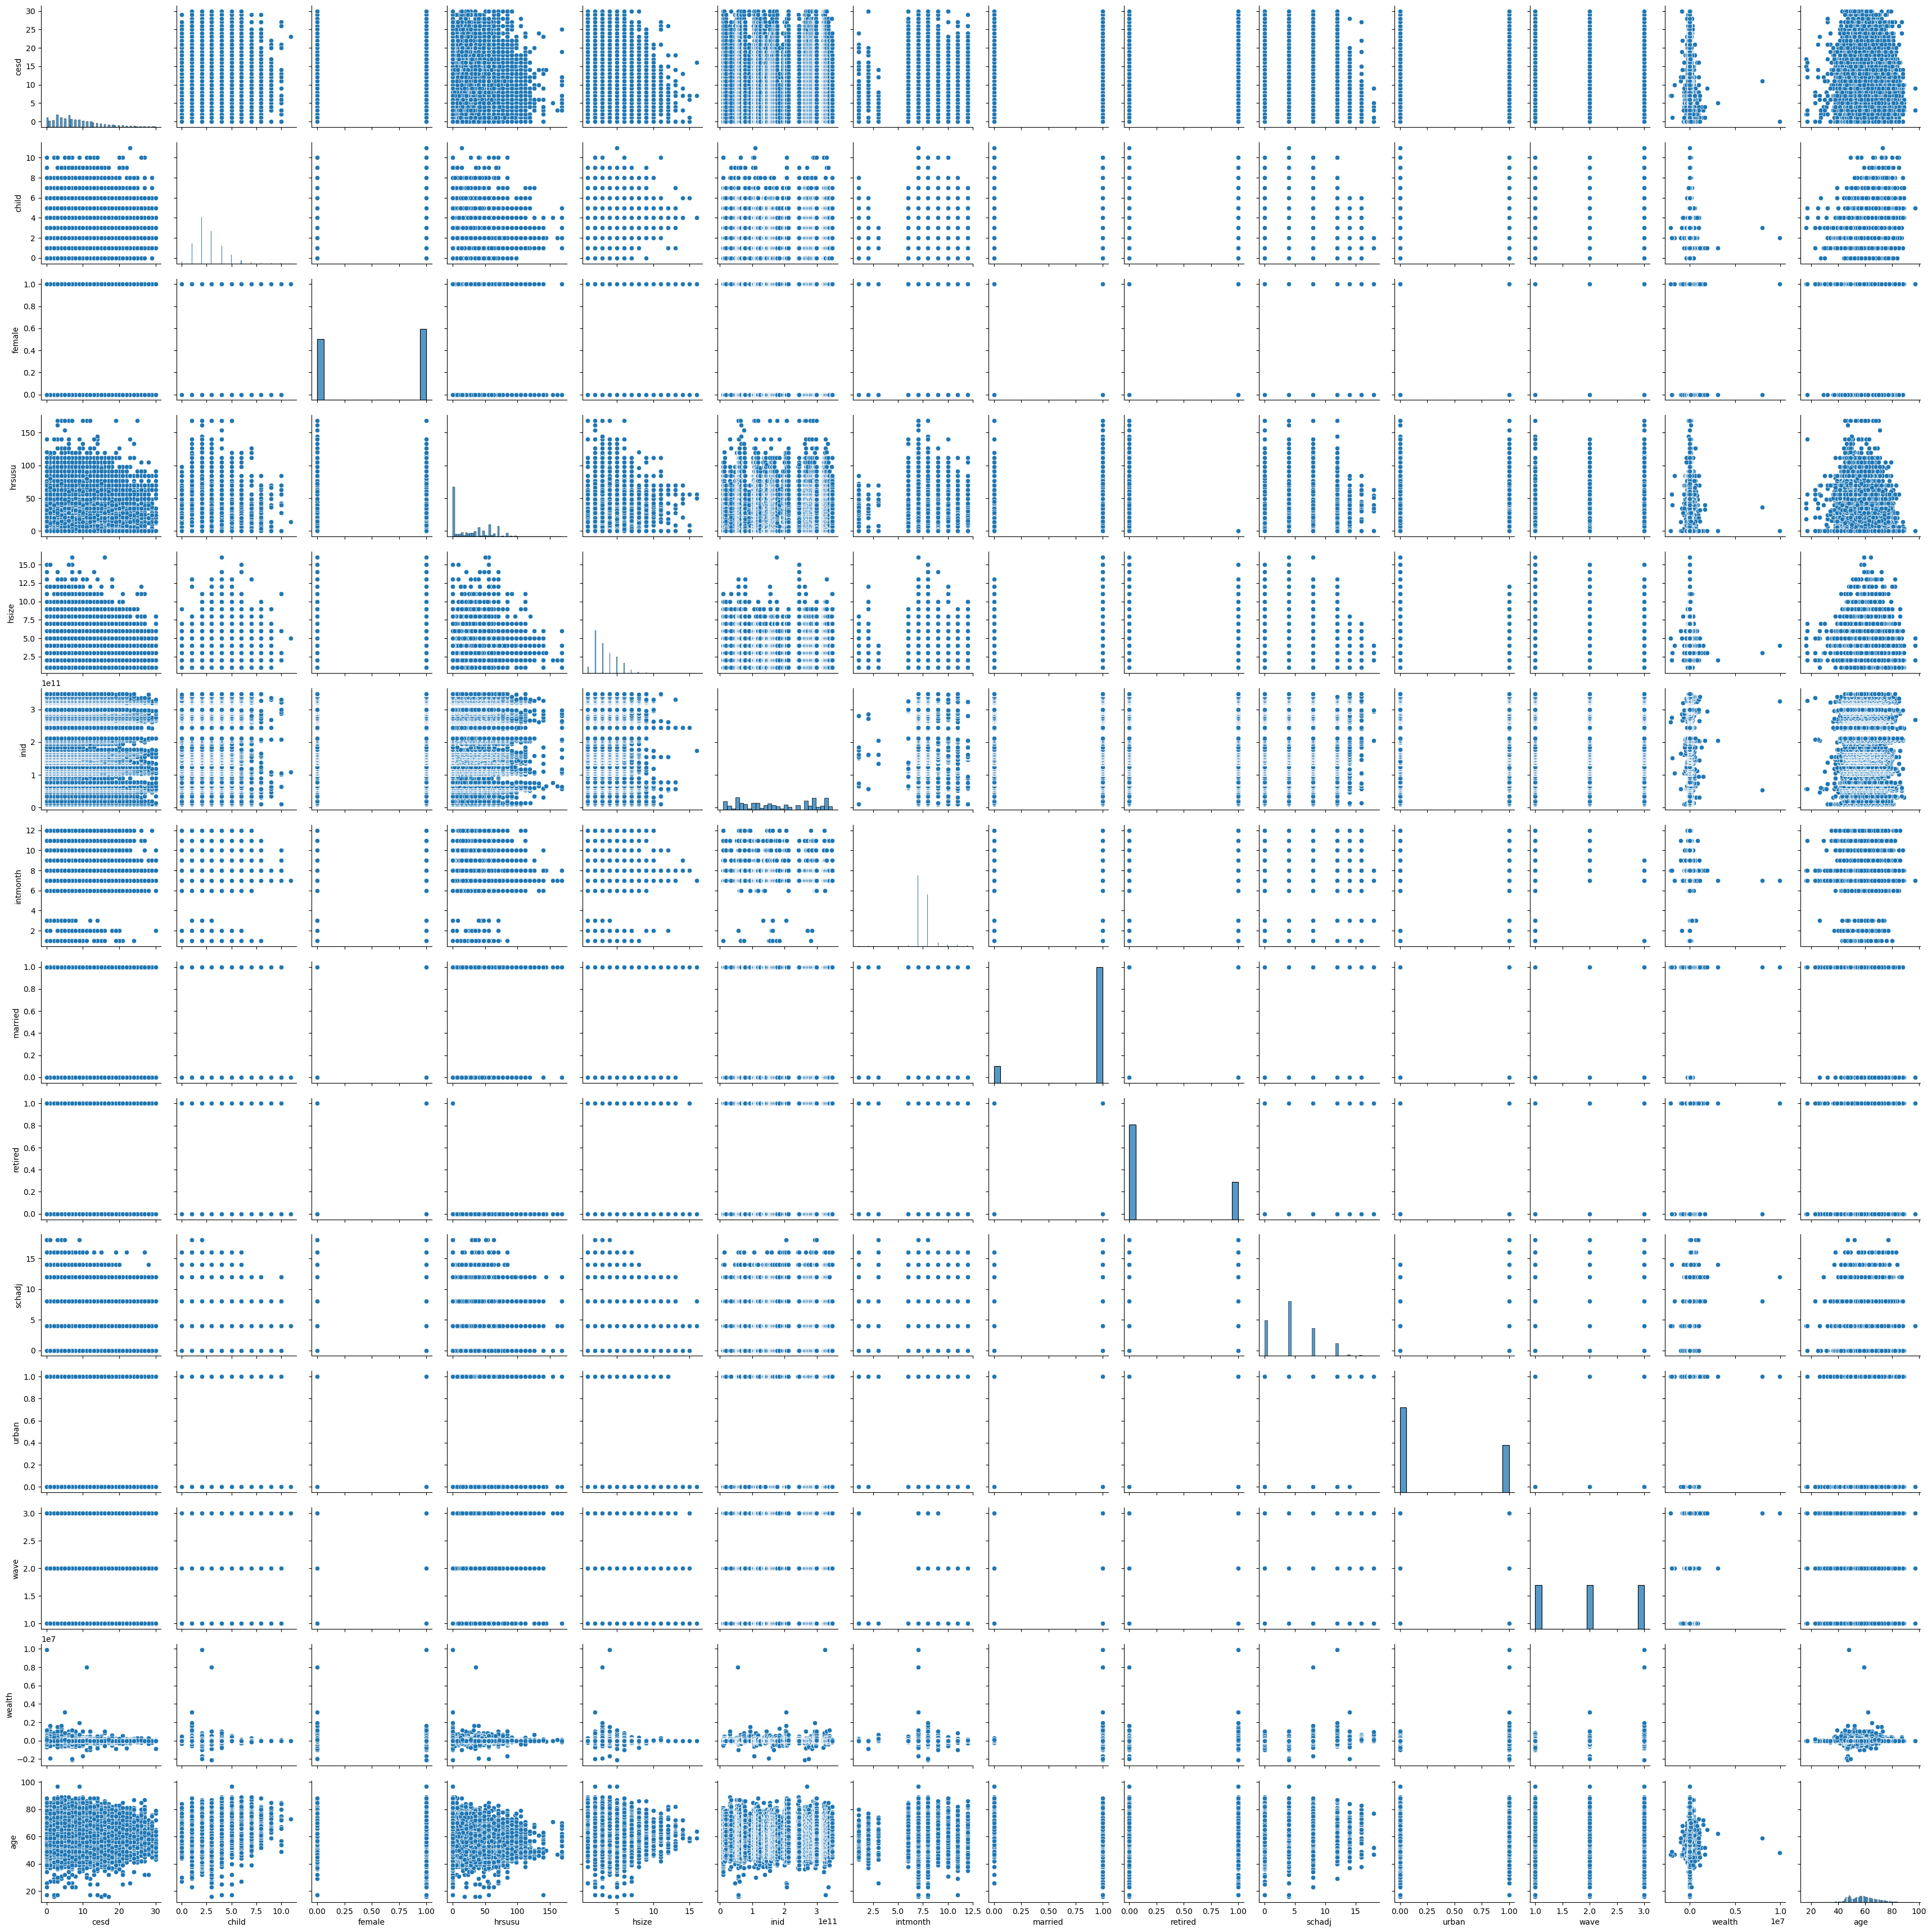

In [3]:
sbn.pairplot(charls)

Del diagrama de dispersión, a modo general llama la atención lo siguiente:
- De la correlacion entre todas las variables con la variable dependiente de resultado 'cesd', la que presenta un claro caso de outliers es wealth vs cesd.
- La proporción entre hombres y mujeres es bastante cercana más no igual.
- La proporción de personas con más observaciones en la variable 'hrsusu' correspondea 0 horas trabajo a la semana.
- En 'retired', casi el 70% de las observaciones corresponden a personas que están jubiladas, lo cual podría estar correlacionado al punto anterior.
- En 'married', casi el 90% de los encuestados son casados

In [4]:
#corr = pg.pairwise_corr(charls, columns=['hrsusu','retired'], method='spearman')
corr = pg.pairwise_corr(charls[['hrsusu','retired']], method='spearman')
corr

,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,hrsusu,retired,spearman,two-sided,34354,-0.707089,"[-0.71, -0.7]",0.0,1.0


De la correlación entre las variables 'hrsusu' y 'retired' usando el metodo Spearman (ya que las variables no presentan distribución normal como para utilizar otro método como Person por ejemplo), se confirma que existe una alta correlación y negativa entre ambas variables, significativa con un valor-p practicamente 0, es por esa razón que para el modelo se eliminará una de ellas y en este caso se escogerá la variable binaria 'retired', ya que 'hrsusu' es continua y tambien por que al abarcar un amplio rango de valores puede entregar una mayor información al momento de explicar la variable de resultado.

1    11457
3    11452
2    11445
Name: wave, dtype: int64

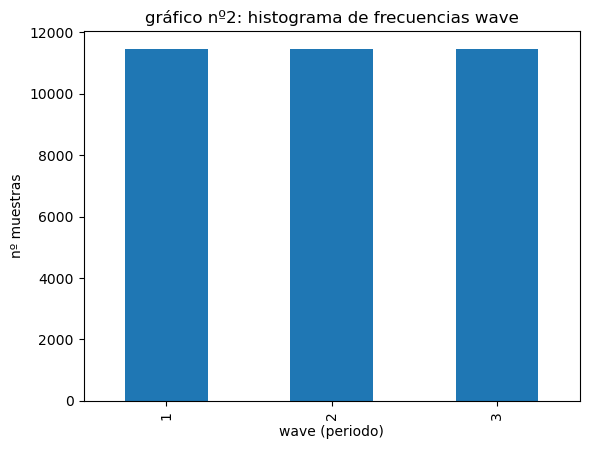

In [5]:
plt.title('gráfico nº2: histograma de frecuencias wave')
plt.xlabel('wave (periodo)')
plt.ylabel('nº muestras')
charls['wave'].value_counts().sort_index().plot(kind='bar')
charls['wave'].value_counts()

Observando el gráfico nº2, se observa que no existe una atrición importante en el panel de datos (pero si la hay), una de las formas para corregir esto podría ser realizando imputación o bien por medio del uso de pesos relativos, sin embargo para efectos prácticos se asumirá que el panel está balanceado dado que el hecho de haber una atrición baja, no es impedimento para las librerias estadisticas para poder realizar una regresión no significativa.

A modo de controlar el efecto promedio que tiene el tiempo o periodo sobre la variable de resultado, se creará un total de 2 variables dicotomicas de 'wave', donde:

- wave_2 = {1: El periodo de la encuesta es el nº2; 0: en otro caso}
- wave_3 = {1: El periodo de la encuesta es el nº3; 0: en otro caso}

Categoria de referencia: El periodo de la encuesta es el nº1 (wave_2=0 y wave_3=0)

Además, como la información con respecto a la variable binaria 'drinkly' en la data estaba de forma de string y no directamente como valores en el conjunto {0,1}, se convertirán manualmente mediante la función map en dichos valores númericos con el fin de evitar eliminar esta variable por dicha problemática.


In [6]:
charls['wave_2']=charls.wave.map({1:0, 2:1, 3:0})
charls['wave_3']=charls.wave.map({1:0, 2:0, 3:1})

charls['Drinkly']=charls.drinkly.map({'1.Yes':1, '0.None':0})
charls.drop(['drinkly'], axis=1, inplace=True)

Como la variable intmonth es categorica ya que representa el mes del año en el que la persona fue entrevistada, podría convertirse en una serie de variables dummy, sin embargo el hacer esto implica tener en el modelo 9 variables dicotomicas (pues ninguna persona fue entrevistada en abril ((intmonth=4) o mayo (intmonth=5)) generando un exceso de variables explicativas.

A pesar de eso, en base al gráfico nº3 y por simple inspección, resulta interesante pensar que es posible agrupar la variable intmonth en grupos equitativos, en este caso 3 cuatrimestres, donde en el primero se incluyan los meses desde el 1 hasta el 4, en el segundo desde el 5 hasta el 8 y en el último los meses 9 hasta el 12. Con esta idea en mente, en el gráfico se puede observar que el 1º cuatrimestre es en el que menos observaciones tiene registradas; el 2º cuatrimestre, el cual concentra por lejos la mayor parte de las observaciones en el mes 7 y 8; por último el 3º cuatrimestre presenta una concentracion de observaciones mucho menor que el 2º cuatrimestre pero mayor al 1º cuatrimestre. Al hacer esto se reduce enormemente la cantidad de variables a incluir en el modelo a final a solamente 2 variables dummy:


- intmonth_2 = {1: Si la persona fue encuestada en el 2º cuatrimestre; 0: en otro caso}
- intmonth_3 = {1: Si la persona fue encuestada en el 3ª cuatrimestre; 0: en otro caso}

Categoria de referencia: La persona no fue encuestada en el 1º cuatrimestre (intmonth_2=0 e intmonth_3=0)

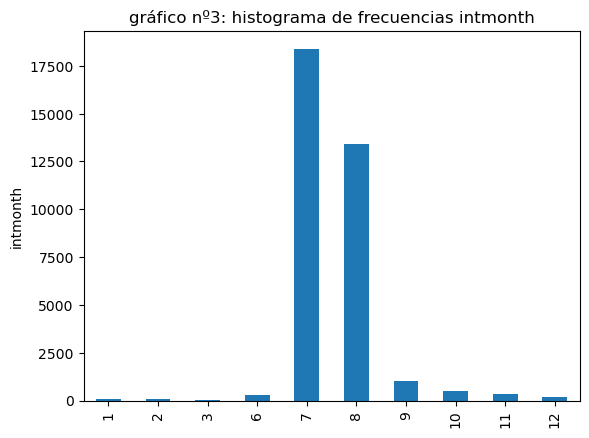

In [7]:
plt.title('gráfico nº3: histograma de frecuencias intmonth')
plt.ylabel('intmonth')
charls['intmonth'].value_counts().sort_index().plot(kind='bar')
charls['intmonth_2']=charls.intmonth.map({1:0, 2:0, 3:0, 4:0, 5:1, 6:1, 7:1, 8:1, 9:0, 10:0, 11:0, 12:0})
charls['intmonth_3']=charls.intmonth.map({1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:1, 10:1, 11:1, 12:1})

charls.drop(['intmonth'], axis=1, inplace=True)

En el gráfico nº4 se detectaron dos outliers y para eliminarlos se ha hecho un subset_0 descartando las observaciones anómalas observadas en dicha gráfica, en el segundo gráfico a partir del susbet_0 se detectaron nuevos outliers y de la misma forma se han ido eliminando; luego de descartar los outliers el total de muestras se redujo a 34352 observaciones.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34352 entries, 0 to 34353
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cesd        34352 non-null  int64  
 1   child       34352 non-null  int64  
 2   female      34352 non-null  int64  
 3   hrsusu      34352 non-null  float64
 4   hsize       34352 non-null  int64  
 5   inid        34352 non-null  float64
 6   married     34352 non-null  int64  
 7   retired     34352 non-null  int64  
 8   schadj      34352 non-null  int64  
 9   urban       34352 non-null  int64  
 10  wave        34352 non-null  int64  
 11  wealth      34352 non-null  float64
 12  age         34352 non-null  int64  
 13  wave_2      34352 non-null  int64  
 14  wave_3      34352 non-null  int64  
 15  Drinkly     34352 non-null  int64  
 16  intmonth_2  34352 non-null  int64  
 17  intmonth_3  34352 non-null  int64  
dtypes: float64(3), int64(15)
memory usage: 5.0 MB


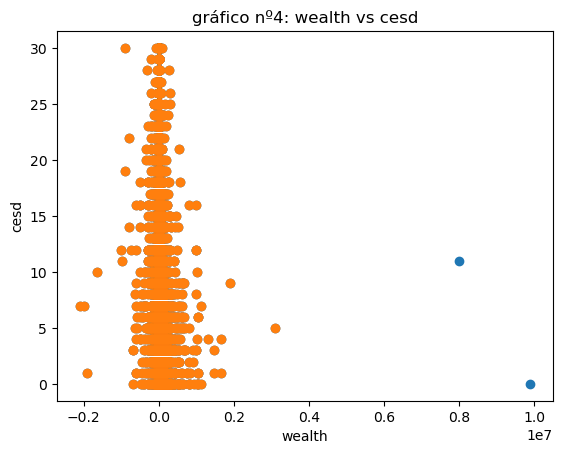

In [8]:
plt.title('gráfico nº4: wealth vs cesd')
plt.xlabel('wealth')
plt.ylabel('cesd')
plt.scatter(charls['wealth'],charls['cesd'])
subset_0=charls.loc[charls['wealth']<0.6*(10**7)]
plt.scatter(subset_0['wealth'],subset_0['cesd'])

subset_0.info()

In [9]:
X=subset_0[['child','Drinkly','hrsusu','hsize','female','intmonth_2','intmonth_3','married','retired','schadj','urban','wealth','age','wave_2','wave_3']]
Xm=(X.groupby(subset_0['inid']).transform('mean'))


X_ID=subset_0[['inid','wave','cesd','child','Drinkly','hrsusu','hsize','female','married','retired','schadj','urban','wealth','age','intmonth_2','intmonth_3','wave_2','wave_3']]
Xc=pd.DataFrame(np.c_[X_ID, Xm], columns=['inid','wave','cesd','child','Drinkly','hrsusu','hsize','female','married','retired','schadj','urban','wealth','age','intmonth_2','intmonth_3','wave_2','wave_3','mchild','mDrinkly','mhrsusu','mhsize','mfemale','mintmonth_2','mintmonth_3','mmarried','mretired','mschadj','murban','mwealth','mage','mwave_2','mwave_3'])

#se establece el index del panel
Xc = Xc.set_index(["inid","wave"])
Xc.describe()

,cesd,child,Drinkly,hrsusu,hsize,female,married,retired,schadj,urban,...,mintmonth_2,mintmonth_3,mmarried,mretired,mschadj,murban,mwealth,mage,mwave_2,mwave_3
count,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,...,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000,34352.000000
mean,8.173643,2.708197,0.331596,27.970722,3.441168,0.537873,0.874592,0.283914,4.677632,0.356195,...,0.935026,0.059676,0.874592,0.283914,4.677632,0.356195,9370.798561,58.223539,0.333168,0.333314
std,6.183829,1.399927,0.470794,28.273270,1.702504,0.498571,0.331185,0.450902,3.857608,0.478881,...,0.113486,0.108508,0.184905,0.229963,2.347706,0.381082,26626.492141,5.243503,0.005736,0.005720
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,-325000.000000,16.000000,0.000000,0.000000
25%,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.940367,0.000000,0.867284,0.157658,3.764706,0.000000,400.000000,56.418803,0.333333,0.333333
50%,7.000000,2.000000,0.000000,21.000000,3.000000,1.000000,1.000000,0.000000,4.000000,0.000000,...,0.992424,0.006873,0.901709,0.250000,4.363636,0.250000,5016.666667,58.000000,0.333333,0.333333
75%,12.000000,3.000000,1.000000,54.000000,4.000000,1.000000,1.000000,1.000000,8.000000,1.000000,...,1.000000,0.055556,0.964912,0.333333,5.500000,0.617284,12873.398374,60.406977,0.333333,0.333333
max,30.000000,11.000000,1.000000,168.000000,16.000000,1.000000,1.000000,1.000000,18.000000,1.000000,...,1.000000,0.666667,1.000000,1.000000,16.000000,1.000000,663010.000000,89.000000,0.500000,0.500000


## Modelo Pooled OLS

La finalidad del analisis será comparar modelos con la misma cantidad de variables explicativas, a modo de evitar concluir o interpretar de forma incorrecta los resultados; entonces haciendo un adelanto al modelo de efectos fijos (FE), al ser las variables 'female' y 'age' constantes por individuo en los periodos de la encuesta, no se pueden incluir en dicho modelo; por lo que la carencia de estas variables en FE y la presencia de las mismas en Efectos aleatorios (RE), se presentaría un problema al realizar el test de Hausman: 1) por la diferencia en la dimensión del vector de parametros y covarianzas entre ambos modelos y 2) en el cálculo de los grados de libertad para dicho test; es por eso que se decidió de antemano erradicar esas 2 variables tanto en Pooled OLS, FE y RE y poder comparar modelos similares en el número de variables explicativas.

Por otro lado, se incluirán todas las demás variables de la base de datos, esto debido a que al menos desde el punto de vista lógico, el efecto que cada una de ellas pueda incidir en la variable explicativa 'cesd', parece  razonable y hace sentido.  

In [10]:
y=Xc['cesd']
#X=Xc[['child','Drinkly','hrsusu','hsize','female','married','schadj','urban','wealth','age','intmonth_2','intmonth_3','wave_2','wave_3']]
X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3']]
X=sm.add_constant(X)

model=lmp.PooledOLS(y,X)
OLS=model.fit(cov_type="robust")
print(OLS)

                          PooledOLS Estimation Summary                          
Dep. Variable:                   cesd   R-squared:                        0.0635
Estimator:                  PooledOLS   R-squared (Between):              0.0845
No. Observations:               34352   R-squared (Within):               0.0386
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0635
Time:                        13:41:58   Log-likelihood                -1.102e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      194.07
Entities:                        3459   P-value                           0.0000
Avg Obs:                       9.9312   Distribution:                F(12,34339)
Min Obs:                       2.0000                                           
Max Obs:                       468.00   F-statistic (robust):             197.23
                            

En base a estos resultados, se puede decir a modo general que en realidad todas las variables explicativas que se ingresaron al modelo son significativas, dado que el valor p de cada una de ellas no sobrepasa el valor de 0.1, por lo que se rechaza la hipotesis nula de que estos coeficientes sean iguales a 0.

Analizando el valor de los coeficientes, para este modelo el coef. que es de mayor importancia o el que más aporta a la explicación de la variable dependiente es el de married; ya que indica que el hecho de que una persona esté casada, disminuye 1.4 el puntaje en la escala de salud mental de la persona que contestó la encuesta.

Además, es interesante ver que la conversión de la variable intmonth que representaba 12 meses a 2 variables dicotomicas que representaban 3 cuatrimestres resultaron ser significativas para este modelo, donde la segunda variable más robusta para el modelo fue intmonth_2, que indica que el hecho de que se encueste a la persona en el segundo cuatrimestre del año aumenta 1.3 el puntaje en la escala de salud mental de esa persona.

En principio se añadieron 2 variables dicotomicas para medir el impacto de cada uno de los 3 periodos en los que se realizó la encuesta, las conclusiones que se pueden hacer al respecto dado que estas variables resultaron ser significativas es que, el efecto que tiene el periodo 2 (wave_2=1) sobre la variable explicativa (cesd) con respecto al periodo inicial (periodo 1), hace que se disminuyan casi 0.5 puntos en la escala de salud mental.

El efecto que tiene la variable 'wealth' sobre la variable resultado (puntaje en la escala de salud mental) es prácticamente nulo.


## Efectos fijos 

In [11]:
#X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3','age','female']]
X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3']]
X=sm.add_constant(X)
model=lmp.PanelOLS(y,X, entity_effects=True)
fe=model.fit(cov_type="robust")
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                   cesd   R-squared:                        0.0416
Estimator:                   PanelOLS   R-squared (Between):              0.0681
No. Observations:               34352   R-squared (Within):               0.0416
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0588
Time:                        13:41:58   Log-likelihood                -1.055e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      111.78
Entities:                        3459   P-value                           0.0000
Avg Obs:                       9.9312   Distribution:                F(12,30881)
Min Obs:                       2.0000                                           
Max Obs:                       468.00   F-statistic (robust):             94.615
                            

En este modelo (FE), a comparación con el modelo anterior:
- La variable 'child' cambió el signo y también aumentó su efecto considerablemente pero a costa de que se perdiera significancia.
- La variable 'Drinkly' aumentó su efecto.
- La variable 'urban' disminuyó su efecto considerablemente.
- La variable 'wealth' "disminuyó" su efecto, pero el valor del coef. sigue siendo prácticamente 0 o nulo.

El P-Value al final de los resultados concluye que el modelo de efectos fijos es significativo y explica de mejor forma la variable dependiente en comparación al modelo Pooled OLS.


## Efectos aleatorios

In [12]:
#X=Xc[['child','Drinkly','hrsusu','hsize','female','married','retired','schadj','urban','wealth','age','intmonth_2','intmonth_3','wave_2','wave_3']]
X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")
print(re)
re.variance_decomposition

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.1831
Estimator:              RandomEffects   R-squared (Between):              0.0861
No. Observations:               34352   R-squared (Within):               0.0412
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0553
Time:                        13:41:58   Log-likelihood                -1.073e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      641.31
Entities:                        3459   P-value                           0.0000
Avg Obs:                       9.9312   Distribution:                F(12,34339)
Min Obs:                       2.0000                                           
Max Obs:                       468.00   F-statistic (robust):             134.74
                            

Effects                   13.222446
Residual                  30.216269
Percent due to Effects     0.304393
Name: Variance Decomposition, dtype: float64

En este modelo (RE), a comparación con el modelo anterior:
- La variable 'child' permanece como no significativa. 
- La variable 'urban' aumentó el efecto que habia disminuido en el modelo de fijos. 
- el efecto de 'wealth' sigue siendo prácticamente despreciable.

Al asumir con este modelo que $Cov(x_{itk},\mu_i) = 0,    \forall t \in \{1,2,3\}, \forall k \in \{1,..,12\}$ , entonces la informacion al final de los resultados indica que la proporción del error compuesto: $\mu_i + U_i$  correspondiente al error no observable fijo $\mu_i$ es de 0.3 y el restante 0.7 es perteneciente al error no observable que varia en el tiempo o idiosincrático $U_i$

## Comparación entre modelos

In [13]:
print(lmp.compare({"Pooled": OLS, "FE": fe, "RE":re}, precision="pvalues"))

                             Model Comparison                            
                                 Pooled              FE                RE
-------------------------------------------------------------------------
Dep. Variable                      cesd            cesd              cesd
Estimator                     PooledOLS        PanelOLS     RandomEffects
No. Observations                  34352           34352             34352
Cov. Est.                        Robust          Robust            Robust
R-squared                        0.0635          0.0416            0.1831
R-Squared (Within)               0.0386          0.0416            0.0412
R-Squared (Between)              0.0845          0.0681            0.0861
R-Squared (Overall)              0.0635          0.0588            0.0553
F-statistic                      194.07          111.78            641.31
P-value (F-stat)                 0.0000          0.0000            0.0000
=====================     ============

P-values reportados en los parentesis:

- Para la variabkle 'child', a partir de los modelos FE y RE; a comparación con el modelo Pooled OLS, pasó de ser significativo a no serlo.
- El efecto de 'Drinkly' no varía demasiado y para los 3 modelos resultó ser significativo.
- 'hsize' para Pooled OLS no era significativo y tanto en FE como en RE resultó sí serlo.
- La variable 'married' es la que mayor efecto tiene en la variable resultado, en los tres modelos.
- 'urban' permaneció siendo significativo al 99% de confianza en los tres modelos, sin embargo entre ellos el valor de su efecto es muy variable.
- En los tres modelos, 'wealth' fue significativo pero su efecto es practicamente nulo en la variable resultado.
- Tanto 'intmonth_2' como 'intmonth_3' resultaron ser significativas en los tres modelos.
- Las variables 'wave_2' y 'wave_3' son significativas en todos los modelos, e indican que el efecto que tiene tanto estar en el periodo 2 como en el periodo 3 hace disminuir el valor de la variable resultado, esto esto, el puntaje de la escala de salud mental.



In [14]:
def hausman(fe, re):
 diff = fe.params-re.params
 psi = fe.cov - re.cov
 dof = diff.size -1
 W = diff.dot(la.inv(psi)).dot(diff)
 pval = stats.chi2.sf(W, dof)
 return W, dof, pval


htest = hausman(fe, re) 
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 25.560123100482496, df = 12, p-value = 0.012380618444528552


El rechazo del test de Hausman al 95% de confianza refleja que el supuesto que se utiliza en el modelo RE, es decir, $Cov(x_{itk},\mu_i) = 0,    \forall t \in \{1,2,3\}, \forall k \in \{1,..,12\}$ es incorrecto, favoreciendo el modelo de FE por sobre el RE.

Por lo tanto, dado el resultado del test de Hausman y el valor p entre el modelo FE y Pooled OLS, se concluye que el modelo más significativo es el Modelo de efectos fijos para este set de variables explicativas.

## Modelo de efectos aleatorios correlacionados

In [15]:
X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3','mchild','mDrinkly','mhrsusu','mhsize','mintmonth_2','mintmonth_3','mmarried','mschadj','murban','mwealth','mwave_2','mwave_3']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                   cesd   R-squared:                        0.1848
Estimator:              RandomEffects   R-squared (Between):              0.1050
No. Observations:               34352   R-squared (Within):               0.0416
Date:                Wed, Oct 05 2022   R-squared (Overall):              0.0636
Time:                        13:41:59   Log-likelihood                -1.072e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      324.27
Entities:                        3459   P-value                           0.0000
Avg Obs:                       9.9312   Distribution:                F(24,34327)
Min Obs:                       2.0000                                           
Max Obs:                       468.00   F-statistic (robust):             76.176
                            

In [16]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}, precision="pvalues"))

                              Model Comparison                             
                                     FE                RE               CRE
---------------------------------------------------------------------------
Dep. Variable                      cesd              cesd              cesd
Estimator                      PanelOLS     RandomEffects     RandomEffects
No. Observations                  34352             34352             34352
Cov. Est.                        Robust            Robust            Robust
R-squared                        0.0416            0.1831            0.1848
R-Squared (Within)               0.0416            0.0412            0.0416
R-Squared (Between)              0.0681            0.0861            0.1050
R-Squared (Overall)              0.0588            0.0553            0.0636
F-statistic                      111.78            641.31            324.27
P-value (F-stat)                 0.0000            0.0000            0.0000
============

Lo realmente interesante es que si se comparan todas las variables explicativas entre los modelos FE y CRE, son casi idénticos; por lo más probable es que esto se produjo debido a que no se usaron las variables explicativas que se usaron en los modelos en FE, RE y CRE no son constantes en el tiempo.

A continuación se incluirán las variables 'age' y 'female' en RE y CRE:

In [17]:
X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3','age','female']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
re=model.fit(cov_type="robust")

X=Xc[['child','Drinkly','hrsusu','hsize','married','schadj','urban','wealth','intmonth_2','intmonth_3','wave_2','wave_3','age','female','mchild','mDrinkly','mhrsusu','mhsize','mintmonth_2','mintmonth_3','mmarried','mschadj','murban','mwealth','mwave_2','mwave_3','mage','mfemale']]
X=sm.add_constant(X)
model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")

print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}, precision="pvalues"))

                              Model Comparison                             
                                     FE                RE               CRE
---------------------------------------------------------------------------
Dep. Variable                      cesd              cesd              cesd
Estimator                      PanelOLS     RandomEffects     RandomEffects
No. Observations                  34352             34352             34352
Cov. Est.                        Robust            Robust            Robust
R-squared                        0.0416            0.1923            0.1941
R-Squared (Within)               0.0416            0.0503            0.0507
R-Squared (Between)              0.0681            0.1020            0.1221
R-Squared (Overall)              0.0588            0.0640            0.0730
F-statistic                      111.78            583.96            295.30
P-value (F-stat)                 0.0000            0.0000            0.0000
============

Comparando nuevamente los coeficientes entre FE y CRE:
- Tanto los modelos CRE como en RE consideran que la variable 'age' no es significativa, en cambio, 'female' si lo es, y además es la que más aporta de todas las variables en el efecto de la variable resultado.
- Los coeficientes entre el modelo FE y CRE no son iguales como en la comparación anterior, sin embargo, los valores de los coef., el signo y el valor de los efectos se aproximan bastante, y como el modelo CRE incluye variables explicativas que son constantes en el tiempo, se concluye finalmente que para esta base de datos y de entre estos 4 modelos (Pooled OLS, FE, RE y CRE) el que mejor ajusta los datos de panel es el modelo de Efectos Aleatorios Correlacionados (CRE).
